In [22]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
image_raster = rioxarray.open_rasterio("Data/Image.tif", masked=True)

In [23]:
print(image_raster)

<xarray.DataArray (band: 4, y: 940, x: 766)> Size: 23MB
[2880160 values with dtype=float64]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 6kB 4.082e+05 4.082e+05 ... 4.09e+05 4.09e+05
  * y            (y) float64 8kB 4.606e+06 4.606e+06 ... 4.605e+06 4.605e+06
    spatial_ref  int64 8B 0
Attributes:
    DataType:            Generic
    AREA_OR_POINT:       Area
    RepresentationType:  ATHEMATIC
    scale_factor:        1.0
    add_offset:          0.0


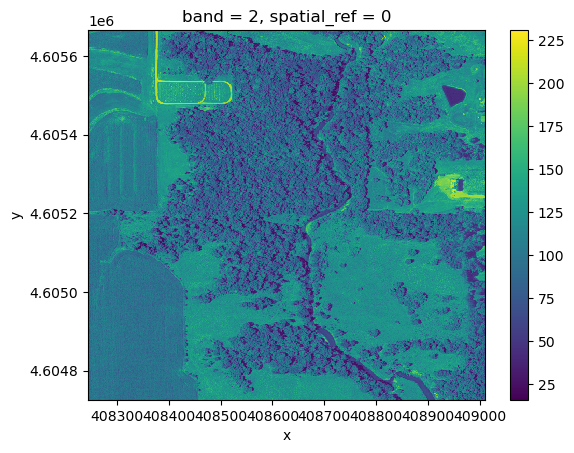

In [31]:
#Separated Bands
image_raster.sel(band=2).plot.imshow()

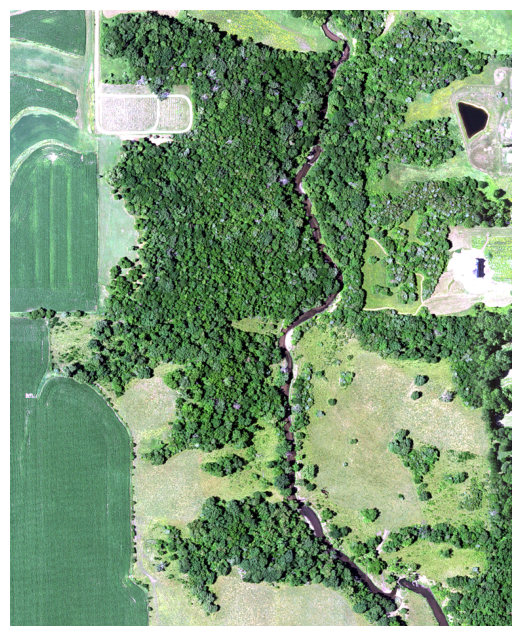

In [26]:
#All bands together

def p_stretch(a, pmin=2, pmax=98):
    vmin = np.nanpercentile(a, pmin)
    vmax = np.nanpercentile(a, pmax)
    out = np.clip((a - vmin) / (vmax - vmin + 1e-9), 0, 1)
    return out

R = p_stretch(image_raster.sel(band=1).compute().values)
G = p_stretch(image_raster.sel(band=2).compute().values)
B = p_stretch(image_raster.sel(band=3).compute().values)

mask = np.isnan(image_raster.sel(band=1).values)  # rioxarray masked=True sets NaN for nodata
RGB = np.dstack([R, G, B])
if mask is not None:
    RGB[mask] = 0  # black where nodata; remove if you don’t want this

plt.figure(figsize=(8, 8))
plt.imshow(RGB)
plt.axis("off")
plt.show()

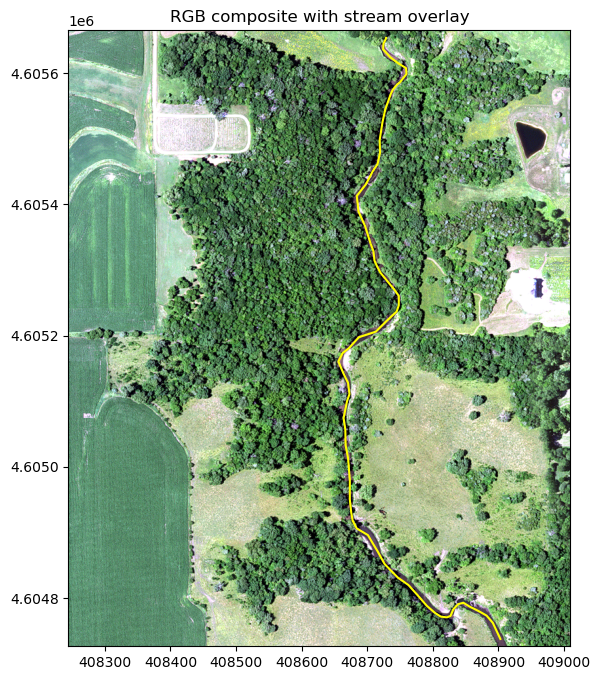

In [27]:
#With polyline
import geopandas as gpd
line_path = "Data/clippedRefinedLines.shp"
gdf = gpd.read_file(line_path)
if gdf.crs is None:
    raise ValueError("The shapefile has no CRS. Assign it (e.g., gdf.set_crs('EPSG:xxxx', inplace=True)).")
if image_raster.rio.crs is None:
    raise ValueError("The raster has no CRS. It needs one to align with vectors.")
gdf = gdf.to_crs(image_raster.rio.crs)

R = p_stretch(image_raster.sel(band=1).compute().values)
G = p_stretch(image_raster.sel(band=2).compute().values)
B = p_stretch(image_raster.sel(band=3).compute().values)
RGB = np.dstack([R, G, B])

# Set extent from raster coordinates
xmin, xmax = float(image_raster.x.min()), float(image_raster.x.max())
ymin, ymax = float(image_raster.y.min()), float(image_raster.y.max())
extent = [xmin, xmax, ymin, ymax]

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(RGB, extent=extent, origin="upper")
gdf.plot(ax=ax, color="yellow", linewidth=1.5)

ax.set_title("RGB composite with stream overlay")
ax.set_aspect("equal")
plt.show()


In [29]:
print("=== Raster Summary ===")
# Spatial reference (CRS)
print("Raster CRS:", image_raster.rio.crs)

# Rows, cols, total pixels
n_bands = image_raster.sizes["band"]
n_rows  = image_raster.sizes["y"]
n_cols  = image_raster.sizes["x"]
print("Rows:", n_rows, "Cols:", n_cols, "Total pixels:", n_rows * n_cols)

# Extent
xmin, xmax = float(image_raster.x.min()), float(image_raster.x.max())
ymin, ymax = float(image_raster.y.min()), float(image_raster.y.max())
print("Raster extent:", (xmin, ymin, xmax, ymax))

# Number of bands
print("Bands:", n_bands)

# Values for first 100 pixels (in raster order = first row, first 100 columns)
vals = image_raster.isel(y=0, x=slice(0,100)).values
# shape = (band, 1, 100) → squeeze row dim
# vals = vals.squeeze(1)
print("Band values for first 100 pixels (array shape:", vals.shape, ")")
print(vals)

print("\n=== Shapefile Summary ===")
print("Shapefile CRS:", gdf.crs)

# Spatial extent (total bounds)
print("Shapefile extent:", gdf.total_bounds)  # [xmin, ymin, xmax, ymax]

# Vertex counts
num_vertices = sum(len(geom.coords) if geom.geom_type=="LineString" else
                   sum(len(p.coords) for p in geom.geoms)
                   for geom in gdf.geometry)
print("Total vertices in shapefile:", num_vertices)

# First 5 vertex coordinates
coords = []
for geom in gdf.geometry:
    if geom.geom_type == "LineString":
        coords.extend(list(geom.coords))
    elif geom.geom_type == "MultiLineString":
        for part in geom.geoms:
            coords.extend(list(part.coords))
    if len(coords) >= 5:
        break
print("First 5 vertex coords:", coords[:5])

=== Raster Summary ===
Raster CRS: EPSG:6370
Rows: 940 Cols: 766 Total pixels: 720040
Raster extent: (408244.5, 4604726.5, 409009.5, 4605665.5)
Bands: 4
Band values for first 100 pixels (array shape: (4, 100) )
[[113. 111. 126. 125. 120. 130. 117. 112.  99. 102.  97.  99. 101. 117.
  126. 131. 126. 148. 155. 138. 136. 150. 160. 166. 160. 166. 168. 159.
  151. 144. 140. 124. 100.  84.  78.  72.  71.  80.  69.  72.  74.  74.
   80.  71.  89.  77.  71.  75.  68.  67.  76.  80.  77.  67.  73. 111.
  145. 143. 122.  87.  70.  67.  71.  76.  81.  76.  89.  68.  69.  78.
   70.  68.  62.  71.  72.  83.  71.  82.  74.  79.  71.  75.  68.  69.
   75.  69.  83.  85.  69. 100. 112. 114.  95.  76.  72.  77.  71.  85.
   83.  84.]
 [152. 152. 153. 151. 150. 150. 138. 134. 133. 134. 128. 135. 135. 134.
  127. 128. 132. 144. 142. 140. 142. 144. 151. 157. 152. 158. 153. 148.
  139. 133. 132. 129. 112. 116. 114. 105.  95. 112. 101. 102. 105.  97.
  105. 107. 116.  97.  97. 102. 101.  99. 102. 109. 109.

In [30]:
import rasterio

# Get affine transform from raster
transform = image_raster.rio.transform()
print("Affine transform:", transform)

# Define row/col (note: col=x index, row=y index)
col = 10
row = 11

# Use rasterio transform to map pixel → world coords
x, y = rasterio.transform.xy(transform, row, col)
print(f"Spatial coordinates of cell (row={row}, col={col}):", (x, y))


Affine transform: | 1.00, 0.00, 408244.00|
| 0.00,-1.00, 4605666.00|
| 0.00, 0.00, 1.00|
Spatial coordinates of cell (row=11, col=10): (np.float64(408254.5), np.float64(4605654.5))


In [32]:
from rasterio.features import rasterize

# Raster geometry
transform = image_raster.rio.transform()
out_shape = (image_raster.sizes["y"], image_raster.sizes["x"])

# 1) Rasterize the polyline → stream mask aligned to the raster grid
#    "crosses" ≈ any pixel the line touches → all_touched=True
stream_mask = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=out_shape,
    transform=transform,
    all_touched=True,
    dtype="uint8",
    default_value=0,
    fill=0,
)

# 2) Get row/col indices of stream pixels
rows, cols = np.where(stream_mask == 1)

print(f"# stream pixels: {len(rows)}")

# 3) Get map coordinates for those pixel centers
xs, ys = rasterio.transform.xy(transform, rows, cols)  # lists

# 4) Extract raster values at stream pixels
#    - single band example (band=1)
vals_band1 = image_raster.sel(band=1).values[rows, cols]

#    - all bands stacked (shape: n_stream_pixels x n_bands)
all_bands = []
for b in image_raster["band"].values:
    all_bands.append(image_raster.sel(band=int(b)).values[rows, cols])
stream_values = np.stack(all_bands, axis=1)

print("Example (first 5 rows/cols/x/y/values):")
for i in range(min(5, len(rows))):
    print(
        f"row={rows[i]}, col={cols[i]}, x={xs[i]:.3f}, y={ys[i]:.3f}, values={stream_values[i].tolist()}"
    )

# stream pixels: 1504
Example (first 5 rows/cols/x/y/values):
row=10, col=484, x=408728.500, y=4605655.500, values=[31.0, 31.0, 41.0, 50.0]
row=11, col=484, x=408728.500, y=4605654.500, values=[37.0, 43.0, 43.0, 33.0]
row=12, col=484, x=408728.500, y=4605653.500, values=[35.0, 39.0, 50.0, 19.0]
row=13, col=484, x=408728.500, y=4605652.500, values=[24.0, 28.0, 41.0, 7.0]
row=14, col=483, x=408727.500, y=4605651.500, values=[37.0, 34.0, 45.0, 9.0]


# stream pixels: 10938
{'row': 6, 'col': 482, 'x': 408726.5, 'y': 4605659.5, 'vals': [51.0, 71.0, 57.0, 132.0]}


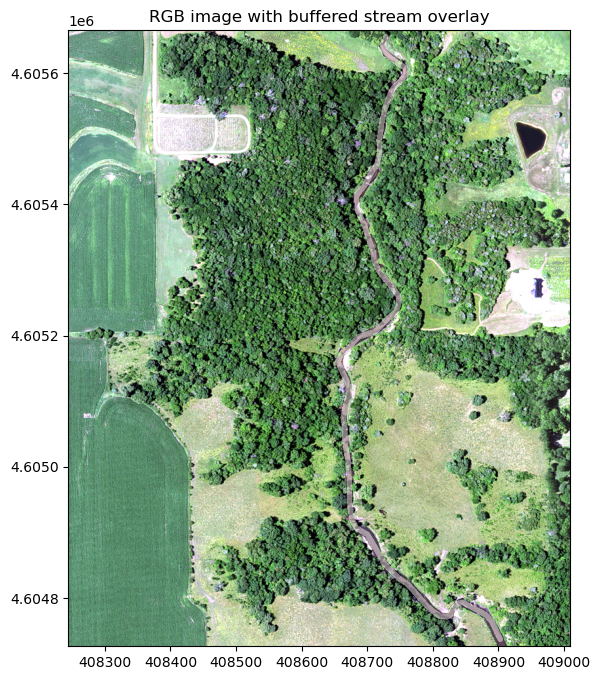

In [38]:
from shapely.ops import unary_union


# 1) Align CRS
gdf = gdf.to_crs(image_raster.rio.crs)

# 2) Pick buffer width ≈ 1 pixel total (radius = 0.5 * pixel size)
transform = image_raster.rio.transform()
res_x = abs(transform.a)
res_y = abs(transform.e)
pixel_size = max(res_x, res_y)
buffer_dist = 4 * pixel_size

# 3) Buffer to make a stream “band” polygon
buffered = gdf.buffer(buffer_dist)
band_poly = unary_union(buffered.geometry)

# 4) Rasterize buffered polygon to the raster grid (1 = stream pixel, 0 = non-stream)
out_shape = (image_raster.sizes["y"], image_raster.sizes["x"])
stream_mask = rasterize(
    [(band_poly, 1)],
    out_shape=out_shape,
    transform=transform,
    all_touched=True,
    dtype="uint8",
    fill=0,
)

# 5) Indices (row, col) of all stream pixels
rows, cols = np.where(stream_mask == 1)
print(f"# stream pixels: {len(rows)}")

# 6) (Optional) Map coordinates for those pixels (centers)
xs, ys = rasterio.transform.xy(transform, rows, cols)

# 7) (Optional) Extract all-band values at those pixels (shape: n_stream_pixels x n_bands)
bands = image_raster["band"].values
values_allbands = np.stack(
    [image_raster.sel(band=int(b)).values[rows, cols] for b in bands],
    axis=1
)

# Peek
if len(rows):
    print({
        "row": int(rows[0]),
        "col": int(cols[0]),
        "x": float(xs[0]),
        "y": float(ys[0]),
        "vals": values_allbands[0].tolist()
    })

# Build RGB image from first 3 bands
R = p_stretch(image_raster.sel(band=1).compute().values)
G = p_stretch(image_raster.sel(band=2).compute().values)
B = p_stretch(image_raster.sel(band=3).compute().values)
RGB = np.dstack([R, G, B])

# Geospatial extent for plotting
xmin, xmax = float(image_raster.x.min()), float(image_raster.x.max())
ymin, ymax = float(image_raster.y.min()), float(image_raster.y.max())
extent = [xmin, xmax, ymin, ymax]

# Plot RGB + stream mask overlay
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(RGB, extent=extent, origin="upper")

# Overlay stream mask with transparency (red highlight)
ax.imshow(
    np.ma.masked_where(stream_mask == 0, stream_mask), 
    extent=extent, origin="upper", cmap="Reds", alpha=0.5
)

ax.set_title("RGB image with buffered stream overlay")
ax.set_aspect("equal")
plt.show()

/tmp/ipykernel_13303/1266566179.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  band_poly = gdf.buffer(buffer_dist).unary_union


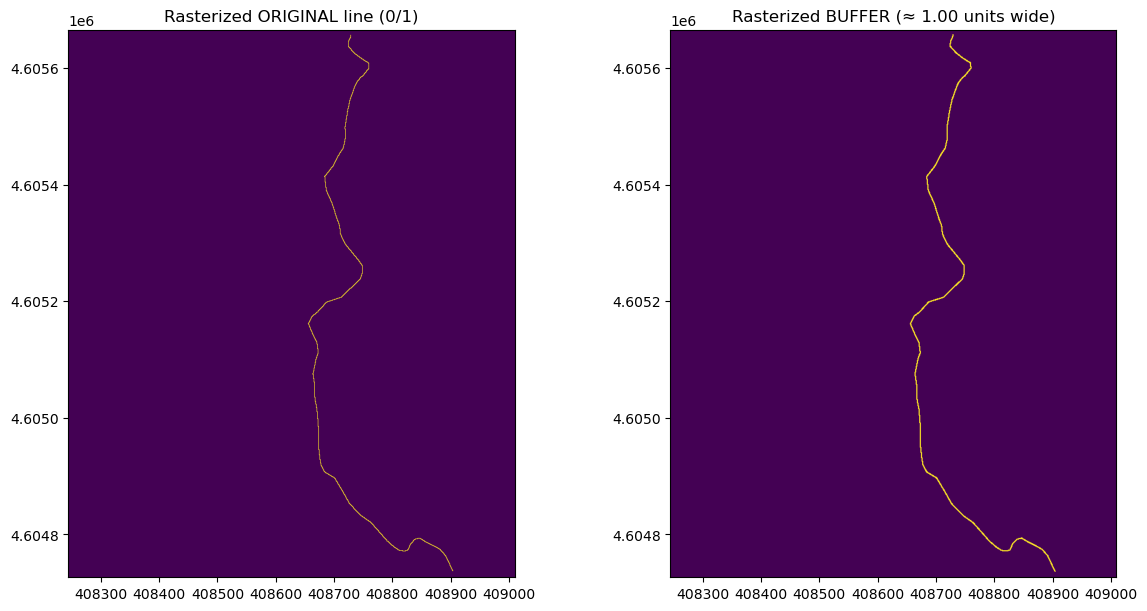

Original line mask - unique values & counts: {0: 718536, 1: 1504}
Buffered band mask - unique values & counts: {0: 717375, 1: 2665}
Both masks are binary (0=non-stream, 1=stream).


In [39]:
# 1) Rasterize ORIGINAL polyline -> 0/1 mask (pixels touched by the line)
line_mask = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=out_shape,
    transform=transform,
    all_touched=True,     # "along the line" ≈ any pixel the line touches
    fill=0,
    dtype="uint8",
)

# 2) Rasterize BUFFERED polyline (stream band) -> 0/1 mask
#    Choose ~1-pixel-wide band: buffer radius ≈ 0.5 * pixel size (in map units)
res_x = abs(transform.a)
res_y = abs(transform.e)
pixel_size = max(res_x, res_y)
buffer_dist = 0.5 * pixel_size

band_poly = gdf.buffer(buffer_dist).unary_union

buffer_mask = rasterize(
    [(band_poly, 1)],
    out_shape=out_shape,
    transform=transform,
    all_touched=True,
    fill=0,
    dtype="uint8",
)

# 3) Visualize masks
xmin, xmax = float(image_raster.x.min()), float(image_raster.x.max())
ymin, ymax = float(image_raster.y.min()), float(image_raster.y.max())
extent = [xmin, xmax, ymin, ymax]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

im0 = axes[0].imshow(line_mask, extent=extent, origin="upper")
axes[0].set_title("Rasterized ORIGINAL line (0/1)")
axes[0].set_aspect("equal")

im1 = axes[1].imshow(buffer_mask, extent=extent, origin="upper")
axes[1].set_title(f"Rasterized BUFFER (≈ {2*buffer_dist:.2f} units wide)")
axes[1].set_aspect("equal")

plt.show()

# 4) Check class labels and counts
u_line, c_line = np.unique(line_mask, return_counts=True)
u_buff, c_buff = np.unique(buffer_mask, return_counts=True)

print("Original line mask - unique values & counts:", dict(zip(u_line.tolist(), c_line.tolist())))
print("Buffered band mask - unique values & counts:", dict(zip(u_buff.tolist(), c_buff.tolist())))

# Optional sanity: ensure masks are binary 0/1
assert set(u_line.tolist()).issubset({0,1}), "Line mask has values other than 0/1."
assert set(u_buff.tolist()).issubset({0,1}), "Buffer mask has values other than 0/1."
print("Both masks are binary (0=non-stream, 1=stream).")

In [41]:
import pandas as pd

label_mask = line_mask   # or: line_mask

# --- extract bands as numpy arrays (shape: y, x) ---
R   = image_raster.sel(band=1).values
G   = image_raster.sel(band=2).values
B   = image_raster.sel(band=3).values
NIR = image_raster.sel(band=4).values

# --- flatten to 1D vectors (one entry per pixel) ---
r   = R.ravel()
g   = G.ravel()
b   = B.ravel()
nir = NIR.ravel()
lbl = label_mask.ravel().astype("int8")

# --- build DataFrame ---
df = pd.DataFrame({
    "Red":   r,
    "Green": g,
    "Blue":  b,
    "NIR":   nir,
    "label": lbl,     # 1 = stream, 0 = non-stream
})

# drop pixels with nodata in any band (NaNs from masked=True)
before = len(df)
df = df.dropna(subset=["Red", "Green", "Blue", "NIR"]).reset_index(drop=True)
after = len(df)

# --- quick checks ---
print(f"Table shape (rows, cols): {df.shape}")
print(f"Dropped {before - after} rows with NaNs (nodata).")
print("Class counts:\n", df["label"].value_counts().rename({0:"non-stream", 1:"stream"}))

# peek at first few rows
df.head()

Table shape (rows, cols): (720040, 5)
Dropped 0 rows with NaNs (nodata).
Class counts:
 label
non-stream    718536
stream          1504
Name: count, dtype: int64


Red  Green   Blue    NIR  label
0  113.0  152.0  101.0  192.0      0
1  111.0  152.0  100.0  198.0      0
2  126.0  153.0  103.0  199.0      0
3  125.0  151.0  107.0  196.0      0
4  120.0  150.0  101.0  188.0      0

In [42]:
# --- parameters ---
tile_h = 224   # pixels in Y (height)
tile_w = 224   # pixels in X (width)

# 1) Get data as (y, x, band)
arr = image_raster.transpose("y", "x", "band").values  # shape: (H, W, C)
H, W, C = arr.shape

# 2) Compute how many full tiles fit; drop the remainder
tiles_y = H // tile_h
tiles_x = W // tile_w
if tiles_y == 0 or tiles_x == 0:
    raise ValueError("Tile size is larger than the image.")

# 3) Crop to full-tiles region
arr_crop = arr[:tiles_y * tile_h, :tiles_x * tile_w, :]  # (tiles_y*tile_h, tiles_x*tile_w, C)

# 4) Reshape into tiles (n_tiles, height, width, bands)
#    Step A: (tiles_y, tile_h, tiles_x, tile_w, C)
blocks5 = arr_crop.reshape(tiles_y, tile_h, tiles_x, tile_w, C)
#    Step B: reorder to (tiles_y, tiles_x, tile_h, tile_w, C)
blocks5 = blocks5.transpose(0, 2, 1, 3, 4)
#    Step C: flatten grid → (n_tiles, tile_h, tile_w, C)
blocks4_hw = blocks5.reshape(tiles_y * tiles_x, tile_h, tile_w, C)

# 5) Final axis order as requested: (chunk_id, width, height, color_band)
#    Swap height and width axes (1 <-> 2)
tiles4D = np.transpose(blocks4_hw, (0, 2, 1, 3))  # shape: (N, tile_w, tile_h, C)

print("tiles4D shape:", tiles4D.shape)  # -> (N_chunks, 224, 224, 4)

tiles4D shape: (12, 224, 224, 4)


In [43]:
from pathlib import Path
import geopandas as gpd
from shapely.geometry import box
import rasterio

# --- params ---
tile_h = 224   # rows
tile_w = 224   # cols
out_dir = Path("Data/stream_chunks")  # output folder for per-chunk shapefiles
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Ensure CRS matches raster
gdf = gdf.to_crs(image_raster.rio.crs)

# 2) Basic raster geometry
H = image_raster.sizes["y"]
W = image_raster.sizes["x"]
tiles_y = H // tile_h
tiles_x = W // tile_w
transform = image_raster.rio.transform()

# 3) Optional speedup: spatial index
sindex = getattr(gdf, "sindex", None)

n_written, n_empty = 0, 0

for ty in range(tiles_y):
    for tx in range(tiles_x):
        # pixel window for this tile
        y0, y1 = ty * tile_h, (ty + 1) * tile_h
        x0, x1 = tx * tile_w, (tx + 1) * tile_w

        # compute tile bounds in map coords using affine transform
        # UL corner of (y0, x0) and LR corner of (y1-1, x1-1)
        left,  top    = rasterio.transform.xy(transform, y0,     x0,     offset="ul")
        right, bottom = rasterio.transform.xy(transform, y1 - 1, x1 - 1, offset="lr")
        tile_poly = box(left, bottom, right, top)  # shapely box(minx, miny, maxx, maxy)

        # narrow to candidates via spatial index (much faster), then clip
        if sindex is not None:
            cand_idx = list(sindex.intersection(tile_poly.bounds))
            gdf_cand = gdf.iloc[cand_idx] if cand_idx else gdf.iloc[[]]
        else:
            gdf_cand = gdf

        gdf_clip = gpd.clip(gdf_cand, tile_poly)

        if gdf_clip.empty:
            n_empty += 1
            continue

        # add chunk metadata (keep names ≤10 chars for Shapefile)
        gdf_clip["chunk_id"] = ty * tiles_x + tx
        gdf_clip["row_block"] = ty
        gdf_clip["col_block"] = tx

        # write one shapefile per chunk
        out_path = out_dir / f"stream_chunk_{ty:03d}_{tx:03d}.shp"
        gdf_clip.to_file(out_path, driver="ESRI Shapefile")
        n_written += 1

print(f"Done. Wrote {n_written} shapefiles to {out_dir} (skipped {n_empty} empty tiles).")

Done. Wrote 7 shapefiles to Data/stream_chunks (skipped 5 empty tiles).
